## CycleGAN From Scratch with PyTorch

# [Link to my Youtube Video Explaining this whole Notebook](https://www.youtube.com/watch?v=wHo4N3njxDY&list=PLxqBkZuBynVRyOJs4RWmB_fKlOVe5S8CR&index=13)

[![Imgur](https://imgur.com/PrgnIAi.png)](https://www.youtube.com/watch?v=wHo4N3njxDY&list=PLxqBkZuBynVRyOJs4RWmB_fKlOVe5S8CR&index=13)


### Dataset - Content

### [Link to Dataset](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/)

Summer2Winter Yosemite dataset consists of 1540 Summer Photos & 1200 Winter Photos with each split into train and test subsets.



This dataset was obtained from UC Berkeley's official directory of CycleGAN Datasets. For more details on the dataset refer the related CycleGAN publication. Work based on the dataset should cite:

In [1]:
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

import glob
import random
from torch.utils.data import Dataset
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Below 4 Lines are when running inside Kaggle
# train_A_paths = glob.glob('../input/summer2winter-yosemite/trainA/*.jpg')
# train_B_paths = glob.glob('../input/summer2winter-yosemite/trainB/*.jpg')
# print('Len of trainA：',len(train_A_paths))
# print('Len of testA：',len(train_B_paths))

# test_A_paths = glob.glob('../input/summer2winter-yosemite/testA/*.jpg')
# test_B_paths = glob.glob('../input/summer2winter-yosemite/testB/*.jpg')
# print('Len of test：',len(test_A_paths))
# print('Len of testB：',len(test_B_paths))

Mounted at /content/drive


In [3]:
!nvidia-smi

Sun Mar 20 11:48:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# HYPERPARAMETERS 
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

hp = Hyperparameters(
    epoch=0,
    n_epochs=200,    
    dataset_train_mode="train",
    dataset_test_mode="test", 
    batch_size=4,        
    lr=.0002,
    decay_start_epoch=100,
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,
    n_critic=5,
    sample_interval=100,
    num_residual_blocks=19,
    lambda_cyc=10.0,
    lambda_id=5.0)

# Root Path for Google Drive
root_path = '/content/drive/MyDrive/All_Datasets/summer2winter_yosemite'

# Kaggle
# root_path = '../input/summer2winter-yosemite'

In [5]:
def convert_to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image


class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned        

        self.files_A = sorted(glob.glob(os.path.join(root, "%sA" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%sB" % mode) + "/*.*"))
        # print("self.files_B ", self.files_B)
        ''' Will print below array with all file names
        ['/content/drive/MyDrive/All_Datasets/summer2winter_yosemite/trainB/2005-06-26 14:04:52.jpg', 
        '/content/drive/MyDrive/All_Datasets/summer2winter_yosemite/trainB/2005-08-02 09:19:52.jpg',..]
        '''

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        # a % b => a is divided by b, and the remainder of that division is returned.

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = convert_to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = convert_to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        
        # Finally ruturn a dict
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

### Bonus Point - How does a % b works when a is smaller than b

https://stackoverflow.com/questions/1535656/how-does-a-modulo-operation-work-when-the-first-number-is-smaller

for instance

2 % 5 the answer is 2.

2 divided by 5 (integer division) is 0 with a remainder of 2.

2 = 0 x 5 + 2

In [6]:
print(2 % 5)
print(2 % 8)
print(2 % 15000)

2
2
2


In [7]:
# Methods for Image Visualization

def show_img(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()
'''  The reason for doing "np.transpose(npimg, (1, 2, 0))"

PyTorch modules processing image data expect tensors in the format C × H × W.
Whereas PILLow and Matplotlib expect image arrays in the format H × W × C
so to use them with matplotlib you need to reshape it
to put the channels as the last dimension:

I could have used permute() method as well like below 
plt.imshow(pytorch_tensor_image.permute(1, 2, 0))
'''

def to_img(x):    
    x = x.view(x.size(0)*2, hp.channels, hp.img_size, hp.img_size)
    return x

import matplotlib.image as mpimg

def plot_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)  
    plt.show()

## Get Train and Validation Dataloader

In [8]:

transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

train_dataloader = DataLoader(
    ImageDataset(root_path, mode=hp.dataset_train_mode, transforms_=transforms_),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=1,
)
val_dataloader = DataLoader(
    ImageDataset(root_path, mode=hp.dataset_test_mode, transforms_=transforms_),
    batch_size=16,
    shuffle=True,
    num_workers=1,
)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## Visualize some sample images

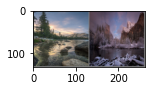

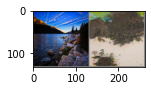

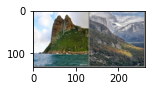

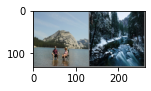

In [9]:

pic_size = 2 

dataiter = iter(train_dataloader)
images = dataiter.next()

for i in range(len(images["A"])):
  show_img(make_grid([images["A"][i],images["B"][i]]), size=pic_size)

## Replay Buffer 

As per the paper -  To reduce model oscillation, we update the discriminator using a history of generated images rather than the ones produced by the latest generators. We keep an image buffer that stores the 50 previously created images.

And here is the link the Paper Published in 2017 by Shrivastava - https://arxiv.org/pdf/1612.07828.pdf


This is another strategy used to stabilize the CycleGAN Training

Replay buffer is used to train the discriminator. Generated images are added to the replay buffer and sampled from it.

The replay buffer returns the newly added image with a probability of 0.5. 

Otherwise, it sends an older generated image and replaces the older image with the newly generated image.

This is done to reduce model oscillation.

In [10]:
# ReplayBuffer
class ReplayBuffer:
    # We keep an image buffer that stores
    # the 50 previously created images.
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                # Returns newly added image with a probability of 0.5.
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[
                        i
                    ] = element  # replaces the older image with the newly generated image.
                else:
                    # Otherwise, it sends an older generated image and
                    to_return.append(element)
        return Variable(torch.cat(to_return))


''' torch.cat: Concatenates the given sequence of seq tensors in the given dimension. The consequence is that a specific dimension changes size e.g. dim=0 then you are adding elements to the row which increases the dimensionality of the column space. '''

' torch.cat: Concatenates the given sequence of seq tensors in the given dimension. The consequence is that a specific dimension changes size e.g. dim=0 then you are adding elements to the row which increases the dimensionality of the column space. '

## Learning Rate scheduling with `lr_lambda`

As per the paper -  "We keep the same learning rate
for the first 100 epochs and linearly decay the rate to zero
over the next 100 epochs."

### First, I am creating a class `LambdaLR(n_epochs, offset, decay_start_epoch)` - Lets understand how its working

Following the Paper, in my `LambdaLR` class the `decay_start_epoch` hyperparameter is kept at 100

And then just before training, I will invoke the `LambdaLR()` method as below, to set the `lr_scheduler_G`

```py
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)
```

Where `lr_lambda` (is a function or list) – A function which computes a multiplicative factor given an integer parameter epoch, or a list of such functions, one for each group in optimizer.param_groups.

So basically, below ia a simplified application of the lambda function.

```py
lambda_func = lambda epoch: 1 - max(0, epoch - decay_start_epoch)/(n_epochs - decay_start_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
```

### Understanding `lr_lambda` arg in `torch.optim.lr_scheduler.LambdaLR`

lr_lambda Sets the learning rate of each parameter group to the initial lr times a given function. When last_epoch=-1, sets initial lr as lr.

The new learning rate is always calculated like that:

### lr_epoch = lr_initial ∗ Lambda(epoch)

In [11]:

class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        # Below line checks whether the current epoch has exceeded the decay epoch(which is 100)
        # e.g. if current epoch is 80 then max (0, 80 - 100) will be 0. 
        # i.e. then entire numerator will be 0 - so 1 - 0 is 1
        # i.e. the original LR remains as it is.
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

#### So e.g. for epoch=110, the above function `LambdaLR` will return as below

`return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)`

will be

1.0 - max(0, 110 + 0 - 100) / (200 - 100) 

= 1.0 - max(0, 10) / (100) 

= 1 - 1/10 = 0.9

So that means the Decay Factor of the Learning rate for epoch=110 is 0.9 i.e. the Learning rate would be reduced as below

New LR = Initial LR * 0.9

### Similarly for epoch=120, `LambdaLR` will return as below

1.0 - max(0, 120 + 0 - 100) / (200 - 100) 

= 1.0 - max(0, 20) / (100) 

= 1 - 1/5 = 0.8

So that means the Decay Factor of the Learning rate for epoch=110 is 0.9 i.e. the Learning rate would be reduced as below

New LR = Initial LR * 0.8

--------------------------------------

#### Overall, in my `LambdaLR` class - the implementation logic goes like this

- In-order to linearly decay the learning rate after 100 epoch the lambda function checks whether the current epoch has exceeds the `decay_start_epoch`(which is 100).

- If current epoch is less than `decay_start_epoch`(which is 100) it returns 1. So that initial lr remain same for the first 100 epochs.

- If the current epoch has exceeded the `decay_start_epoch`(which is 100) the initial lr will be decreased through out the rest of the epochs among total epochs(rest 100 epoch out of total 200 epochs of training).

- If we equally divide the lr for the last 100 epochs and keep subtracting from "Base-LR" or "Initial LR", it will reach to 0 by the end of the last 100 epochs.

- As lambda lr multiply initial lr with given function, epoch beyond the `decay_start_epoch` will sum up the consistent decrease in lr value from staring of decay epoch(which is 100) to the current epoch(for example 110)).

As it does not have the decayed lr at previous epochs(here epoch 109 in case of current epoch 110) and only have Base lr or the Initial LR, it sum up the decrement occurred in lr for the previous epoch.

--------------------------------------------------


### Initialize convolution layer weights to N(0,0.02)

In [12]:
def initialize_conv_weights_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# GENERATOR & DISCRIMINATOR

### Residual Block

As per the paper - " Reflection padding was used to reduce artifacts.
A residual block contains two 3 × 3 convolutional layers with the same number of filters on both layer. "


<blockquote>
<p>**7.2. Network architectures** -->Generator architectures -->"We use 6 residual blocks for 128 × 128 training images, and 9 residual blocks for 256 × 256 or higher-resolution training images."

"Let c7s1-k denote a 7×7 Convolution-InstanceNormReLU layer with k filters and stride 1. dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2. Reflection padding was used to reduce artifacts. Rk denotes a residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layer. uk denotes a 3 × 3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters."

"The network with 9 residual blocks consists of:
**"c7s1-64,d128,d256,R256,R256,R256, R256,R256,R256,R256,R256,R256,u128 u64,c7s1-3"**</p>
</blockquote>

In [13]:
##############################################
# Residual block with two convolution layers.
##############################################
class ResidualBlock(nn.Module):
    def __init__(self, in_channel):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Reflection padding is used because it gives better image quality at edges.
            nn.Conv2d(in_channel, in_channel, 3), # Paper says - same number of filters on both layer.
            nn.InstanceNorm2d(in_channel),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channel, in_channel, 3),
            nn.InstanceNorm2d(in_channel),
        )

    def forward(self, x):
        return x + self.block(x)


---

### Parameters in torch.nn.conv2d()

```py
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

```

Where

* in_channels (int) – Number of channels/filters in the input image

* out_channels (int) – Number of channels/filters produced by the convolution

* kernel_size (int or tuple) – Size of the convolving kernel

* stride (int or tuple, optional) – Stride of the convolution. (Default: 1)

* padding (int or tuple, optional) – Zero-padding added to both sides of the input (Default: 0)

* padding_mode (string, optional) – zeros

* dilation (int or tuple, optional) – Spacing between kernel elements. (Default: 1)

* groups (int, optional) – Number of blocked connections from input to output channels. (Default: 1)

* bias (bool, optional) – If True, adds a learnable bias to the output. (Default: True)

---

## The generator

* The generator consists encoder and decoder. It downsample or encode the input image, then interpret the encoding with 9 Residual Blocks having skip connections.After that with a a series of layers it upsample or decode the representation to the size of the fake image.

* Reflection padding “reflects” the row into the padding. It is used mostly for brightness, contrast and for reducing artifact.

* Batch norm normalizes across the mini batch of definite size.On the other hand, Instance normalization normalizes across each channel in each data instead of normalizing across input features in a data. Instance Norm normalizes each batch independently and across spatial locations only.

* Use of instance normalization layers, the normalization process allows to remove instance-specific contrast information from the image content, which simplifies image generation. Thus results in vastly improved images.

![Imgur](https://imgur.com/38kq2bw.png)

As you can see above, the representation size shrinks in the encoder phase, stays constant in the transformer phase, and expands again in the decoder phase.

In [14]:

##############################################
# Generator
##############################################

""" As per Paper -- Generator with 9 residual blocks consists of:
c7s1-64,d128,d256,R256,R256,R256, R256,R256,R256,R256,R256,R256,
u128, u64,c7s1-3
 """

class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_channels = 64
        # I define a variable 'model' which I will continue to update
        # throughout the 3 blocks of Residual -> Downsampling -> Upsampling
        # First c7s1-64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_channels, 7),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        in_channels = out_channels

        # Downsampling
        # d128 => d256
        for _ in range(2):
            out_channels *= 2
            model += [
                nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        """ Residual blocks - Per Paper
        R256,R256,R256,R256,R256,R256,R256,R256,R256
        """
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_channels)]

        # Upsampling
        # u128 => u64
        for _ in range(2):
            out_channels //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        # Output layer
        model += [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(out_channels, channels, 7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

#### Meaning for *model in `nn.Sequential(*model)` 

The syntax is to use the symbol * to take in a variable number of arguments

*args allows you to do is take in more arguments than the number of formal arguments that you previously defined

## Discriminator

As per the Paper :

<blockquote>
<p>

**7.2. Network architectures - Discriminator architectures**

"For discriminator networks, we use 70 × 70 PatchGAN [22]. Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2. After the last layer, we apply a convolution to produce a 1-dimensional output. We do not use InstanceNorm for the first C64 layer. We use leaky ReLUs with a slope of 0.2. The discriminator architecture is:" C64-C128-C256-C512
<p/>
<blockquote/>

Not listed in the paper, the model also has a final hidden layer C512 with a 1×1 stride. 

Given the model is mostly used with 256×256 sized images as input, the size of the output feature map of activations is 16×16. If 128×128 images were used as input, then the size of the output feature map of activations would be 8×8.

![Imgur](https://imgur.com/ti5xUof.png)

In [15]:

##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_channels, out_channels, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # C64 -> C128 -> C256 -> C512
        self.model = nn.Sequential(
            *discriminator_block(channels, out_channels=64, normalize=False),
            *discriminator_block(64, out_channels=128),
            *discriminator_block(128, out_channels=256),
            *discriminator_block(256, out_channels=512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=1)
        )
        # With nn.ZeroPad2d((1, 0, 1, 0)) I am Zero padding
        # on top and left to keep the output height and width same with the 4×4 kernel

    def forward(self, img):
        return self.model(img)

### Hyperparameters

The main hyperparameters for the discriminator are, namely, number of output filters, kernel size and stride. A trivial configuration is shown in Table 1. Further tuning is needed when training the model.

![Imgur](https://imgur.com/Ia7lyc2.png)

We also use padding to maintain the information of pixels on the boundary of the image.

-------------------------------


## So where is PatchGAN Implemented above.

Ans is PatchGAN is in-built in the very structure in above.

First, noting again that **The main difference between a PatchGAN and a regular GAN discriminator is that - the regular GAN maps an input image to a single scalar output in the range of [0,1], indicating the probability of the image being real or fake, while PatchGAN provides Matrix as the output with each entry signifying whether its corresponding patch is real or fake.**

The architecture for our Discriminator here, is as follows:

### C64 => C128 => C256 => C512

This is referred to as a 3-layer PatchGAN in the CycleGAN and Pix2Pix nomenclature, as excluding the first hidden layer, the model has three hidden layers that could be scaled up or down to give different sized PatchGAN models.

In PatchGAN, given for example image of size 256x256, the PatchGAN maps from that 256x256 to an NxN Matrix of outputs X, where each `X_ij` of that NxN Matrix signifies whether the patch `ij` (in X) in the image is real or fake. So each of this `X_ij` value (which is a single scaler value) is a probability for the likelihood that a patch in the input image is real.

We can test it with below code, that just calculates the output shape of the Matrix given to a PatchGAN network.

In [16]:
def get_input_size(output_size, filter_size, stride):
    return (output_size - 1) * stride + filter_size

# Now invoke above method to calculate the size of various layers in 
# Discriminator Network

last_layer = get_input_size(output_size=1, filter_size=4, stride=1)

fourth_layer_input_size = get_input_size(output_size=last_layer, filter_size=4, stride=1)
print("fourth_layer ", fourth_layer_input_size)

"""Receptive field: 7"""
third_layer_input_size = get_input_size(output_size=fourth_layer_input_size, filter_size=4, stride=2)
print("third_layer_input_size ", third_layer_input_size)

"""Receptive field: 16"""
second_layer_input_size = get_input_size(output_size=third_layer_input_size, filter_size=4, stride=2)
print('second_layer_input_size ', second_layer_input_size)

"""Receptive field: 34"""
first_layer_input_size = get_input_size(output_size=second_layer_input_size, filter_size=4, stride=2)
print('first_layer_input_size ', first_layer_input_size)

"""Receptive field: 70"""

fourth_layer  7
third_layer_input_size  16
second_layer_input_size  34
first_layer_input_size  70


'Receptive field: 70'

In [17]:
# SETUP, LOSS, INITIALIZE MODELS and BUFFERS

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

# Loss functions
# Creating criterion object that will measure the error between the prediction and the target.
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

input_shape = (hp.channels, hp.img_size, hp.img_size)

# Initialize generator and discriminator
Gen_AB = GeneratorResNet(input_shape, hp.num_residual_blocks)
Gen_BA = GeneratorResNet(input_shape, hp.num_residual_blocks)
Disc_A = Discriminator(input_shape)
Disc_B = Discriminator(input_shape)

if cuda:
    Gen_AB = Gen_AB.cuda()
    Gen_BA = Gen_BA.cuda()
    Disc_A = Disc_A.cuda()
    Disc_B = Disc_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

# Initialize weights
Gen_AB.apply(initialize_conv_weights_normal)
Gen_BA.apply(initialize_conv_weights_normal)
Disc_A.apply(initialize_conv_weights_normal)
Disc_B.apply(initialize_conv_weights_normal)

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

Using CUDA


In [18]:
# SAMPLING IMAGES
def save_img_samples(batches_done):
    """Saves a generated sample from the test set"""
    print('batches_done ', batches_done)
    imgs = next(iter(val_dataloader))
    Gen_AB.eval()
    Gen_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = Gen_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = Gen_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=16, normalize=True)
    real_B = make_grid(real_B, nrow=16, normalize=True)
    fake_A = make_grid(fake_A, nrow=16, normalize=True)
    fake_B = make_grid(fake_B, nrow=16, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)    
    path =  root_path + "/%s.png" % (batches_done)    # Path when running in Google Colab
    # path =  '/kaggle/working' + "/%s.png" % (batches_done)    # Path when running inside Kaggle
    save_image(image_grid, path, normalize=False)    
    return path  

## Optimizers

In [19]:
optimizer_G = torch.optim.Adam(
    itertools.chain(Gen_AB.parameters(), Gen_BA.parameters()), lr=hp.lr, betas=(hp.b1, hp.b2)
)
optimizer_Disc_A = torch.optim.Adam(Disc_A.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

optimizer_Disc_B = torch.optim.Adam(Disc_B.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

lr_scheduler_Disc_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_A, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

lr_scheduler_Disc_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_B, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

''' So generally both torch.Tensor and torch.cuda.Tensor are equivalent. You can do everything you like with them both.

The key difference is just that torch.Tensor occupies CPU memory while torch.cuda.Tensor occupies GPU memory. Of course operations on a CPU Tensor are computed with CPU while operations for the GPU / CUDA Tensor are computed on GPU. '''
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [20]:
def train(
    Gen_BA,
    Gen_AB,
    Disc_A,
    Disc_B,
    train_dataloader,
    n_epochs,
    criterion_identity,
    criterion_cycle,
    lambda_cyc,
    criterion_GAN,
    optimizer_G,
    fake_A_buffer,
    fake_B_buffer,
    clear_output,
    optimizer_Disc_A,
    optimizer_Disc_B,
    Tensor,
    sample_interval,
    lambda_id,
):
    # TRAINING
    prev_time = time.time()
    for epoch in range(hp.epoch, n_epochs):
        for i, batch in enumerate(train_dataloader):

            # Set model input
            real_A = Variable(batch["A"].type(Tensor))
            real_B = Variable(batch["B"].type(Tensor))

            # Adversarial ground truths
            valid = Variable(
                Tensor(np.ones((real_A.size(0), *Disc_A.output_shape))),
                requires_grad=False,
            )
            fake = Variable(
                Tensor(np.zeros((real_A.size(0), *Disc_A.output_shape))),
                requires_grad=False,
            )

            #########################
            #  Train Generators
            #########################

            Gen_AB.train() # Gen_AB(real_A) will take real_A and produce fake_B
            Gen_BA.train() # Gen_BA(real_B) will take real_B and produce fake_A

            """
            PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it.
            Otherwise, it will have old information from a previous iteration.
            """
            optimizer_G.zero_grad()

            # Identity loss
            # First pass real_A images to the Genearator, that will generate A-domains images
            loss_id_A = criterion_identity(Gen_BA(real_A), real_A)
            ''' So Gen_BA() was actually supposed to take real_B and and produce images for domain A
            but for calculating Identity loss I will pass to Gen_BA() the target domain images itself
            so ideally in this case, Gen_BA() should work as an identity function
            i.e. its output should be the input itself. And if there's a difference between 
            input and output, then that should be my Identity Loss.
            
            '''
            

            # Then pass real_B images to the Genearator, that will generate B-domains images
            loss_id_B = criterion_identity(Gen_AB(real_B), real_B)

            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN losses for GAN_AB
            fake_B = Gen_AB(real_A)
            loss_GAN_AB = criterion_GAN(Disc_B(fake_B), valid)

            # GAN losses for GAN_BA
            fake_A = Gen_BA(real_B)
            loss_GAN_BA = criterion_GAN(Disc_A(fake_A), valid)

            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle Consistency losses
            reconstructed_A = Gen_BA(fake_B)

            """
            Forward Cycle Consistency Loss
            Forward cycle loss:  lambda * ||G_BtoA(G_AtoB(A)) - A|| (Equation 2 in the paper)
            Compute the cycle consistency loss by comparing the reconstructed reconstructed_A images with real real_A  images of domain A.
            Lambda for cycle loss is 10.0. Penalizing 10 times and forcing to learn the translation.
            """
            loss_cycle_A = criterion_cycle(reconstructed_A, real_A)

            reconstructed_B = Gen_AB(fake_A)

            """
            Backward Cycle Consistency Loss
            Backward cycle loss: lambda * ||G_AtoB(G_BtoA(B)) - B|| (Equation 2 of the Paper)
            Compute the cycle consistency loss by comparing the reconstructed reconstructed_B images with real real_B images of domain B.
            Lambda for cycle loss is 10.0. Penalizing 10 times and forcing to learn the translation.
            """
            loss_cycle_B = criterion_cycle(reconstructed_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            """
            Finally, Total Generators Loss and Back propagation
            Add up all the Generators loss and cyclic loss (Equation 3 of paper. Also Equation I the code representation of the equation) and perform backpropagation with optimization.
            """
            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

            loss_G.backward()

            """
            Now we just need to update all the parameters!
            Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)
            """
            optimizer_G.step()

            #########################
            #  Train Discriminator A
            #########################

            optimizer_Disc_A.zero_grad()

            # Real loss
            loss_real = criterion_GAN(Disc_A(real_A), valid)
            # Fake loss (on batch of previously generated samples)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(Disc_A(fake_A_.detach()), fake)

            """ Total loss for Disc_A
            And I divide by 2 because as per Paper - "we divide the objective by 2 while
            optimizing D, which slows down the rate at which D learns,
            relative to the rate of G."
            """
            loss_Disc_A = (loss_real + loss_fake) / 2

            """ do backpropagation i.e.
            ∇_Θ will get computed by this call below to backward() """
            loss_Disc_A.backward()

            """
            Now we just need to update all the parameters!
            Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)
            """
            optimizer_Disc_A.step()

            #########################
            #  Train Discriminator B
            #########################

            optimizer_Disc_B.zero_grad()

            # Real loss
            loss_real = criterion_GAN(Disc_B(real_B), valid)
            # Fake loss (on batch of previously generated samples)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(Disc_B(fake_B_.detach()), fake)

            """ Total loss for Disc_B
            And I divide by 2 because as per Paper - "we divide the objective by 2 while
            optimizing D, which slows down the rate at which D learns,
            relative to the rate of G."
            """
            loss_Disc_B = (loss_real + loss_fake) / 2

            """ do backpropagation i.e.
            ∇_Θ will get computed by this call below to backward() """
            loss_Disc_B.backward()

            """
            Now we just need to update all the parameters!
            Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)
            """
            optimizer_Disc_B.step()

            loss_D = (loss_Disc_A + loss_Disc_B) / 2

            ##################
            #  Log Progress
            ##################

            # Determine approximate time left
            batches_done = epoch * len(train_dataloader) + i
            batches_left = n_epochs * len(train_dataloader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time)
            )
            prev_time = time.time()

            print(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                % (
                    epoch,
                    n_epochs,
                    i,
                    len(train_dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    loss_cycle.item(),
                    loss_identity.item(),
                    time_left,
                )
            )

            # If at sample interval save image
            if batches_done % sample_interval == 0:
                clear_output()
                plot_output(save_img_samples(batches_done), 30, 40)


batches_done  300


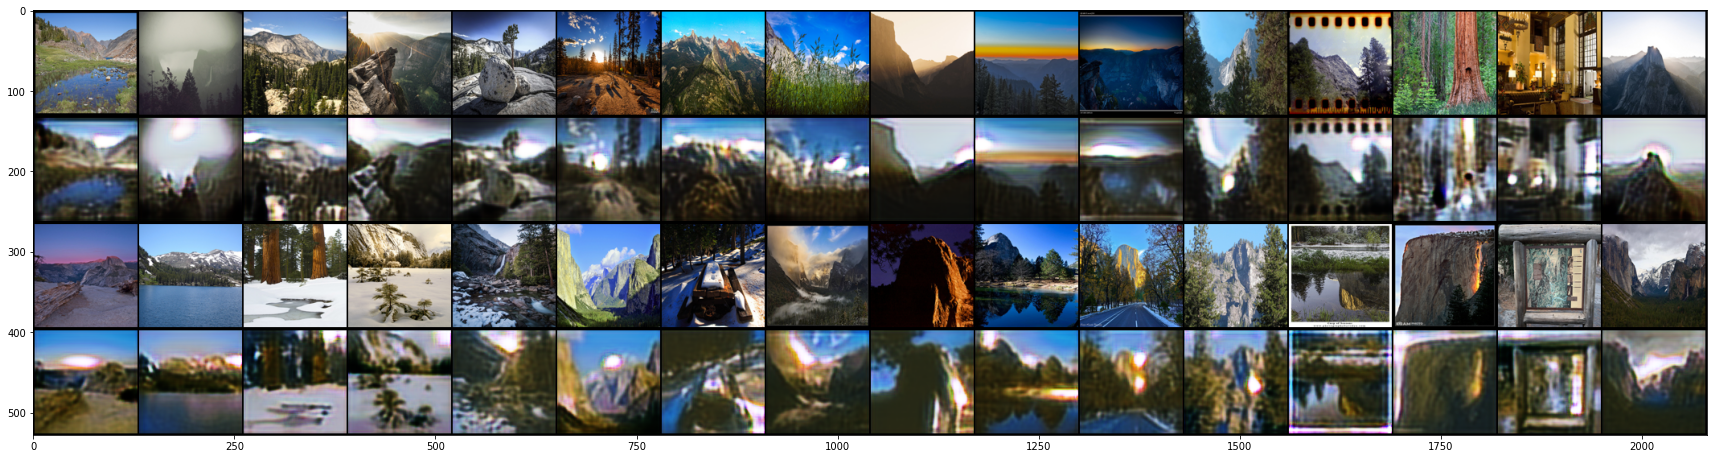

[Epoch 0/200] [Batch 301/308] [D loss: 0.244106] [G loss: 4.137887, adv: 0.393322, cycle: 0.263701, identity: 0.221510] ETA: 11 days, 2:37:58.800022
[Epoch 0/200] [Batch 302/308] [D loss: 0.279400] [G loss: 3.720882, adv: 0.496468, cycle: 0.222811, identity: 0.199261] ETA: 2 days, 5:28:15.149210
[Epoch 0/200] [Batch 303/308] [D loss: 0.240228] [G loss: 4.200094, adv: 0.397895, cycle: 0.270643, identity: 0.219154] ETA: 2 days, 5:27:27.800503
[Epoch 0/200] [Batch 304/308] [D loss: 0.225664] [G loss: 4.129733, adv: 0.276228, cycle: 0.270962, identity: 0.228776] ETA: 2 days, 5:42:31.524593
[Epoch 0/200] [Batch 305/308] [D loss: 0.205290] [G loss: 3.612283, adv: 0.320530, cycle: 0.223360, identity: 0.211630] ETA: 2 days, 6:07:13.182912
[Epoch 0/200] [Batch 306/308] [D loss: 0.235527] [G loss: 3.548554, adv: 0.418258, cycle: 0.216355, identity: 0.193349] ETA: 2 days, 5:34:22.176939
[Epoch 0/200] [Batch 307/308] [D loss: 0.226794] [G loss: 3.595704, adv: 0.203624, cycle: 0.232117, identity: 0

KeyboardInterrupt: ignored

In [21]:
train(
    Gen_BA = Gen_BA,
    Gen_AB = Gen_AB,
    Disc_A = Disc_A,
    Disc_B = Disc_B,
    train_dataloader = train_dataloader,
    n_epochs = hp.n_epochs,
    criterion_identity = criterion_identity,
    criterion_cycle = criterion_cycle,
    lambda_cyc = hp.lambda_cyc,
    criterion_GAN = criterion_GAN,
    optimizer_G = optimizer_G,
    fake_A_buffer = fake_A_buffer,
    fake_B_buffer = fake_B_buffer,
    clear_output = clear_output,
    optimizer_Disc_A = optimizer_Disc_A,
    optimizer_Disc_B = optimizer_Disc_B,
    Tensor = Tensor,
    sample_interval = hp.sample_interval,
    lambda_id = hp.lambda_id,
)